<a href="https://colab.research.google.com/github/thomasvicente/-Personal_Projects/blob/main/generative_sentiment_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import multiprocessing
from scipy.stats import beta, bernoulli

good_words = [
    "amazing", "awesome", "beautiful", "best", "brilliant", "charming", "delightful",
    "excellent", "fantastic", "favorite", "friendly", "fun", "great", "happy", "helpful",
    "impressive", "incredible", "joyful", "kind", "lovely", "outstanding", "perfect",
    "positive", "remarkable", "satisfied", "superb", "wonderful", "thrilled", "supportive",
    "inspiring", "pleasant", "enjoyable", "rewarding", "peaceful", "grateful", "compliment",
    "admire", "accomplished", "encouraging", "comfortable", "efficient", "reliable",
    "respected", "captivating", "memorable", "entertaining", "sensational", "elegant"
]

bad_words = [
    "awful", "bad", "boring", "complain", "confused", "disappointing", "disgusting",
    "dreadful", "failure", "frustrating", "hate", "horrible", "irritating", "mediocre",
    "mess", "negative", "painful", "poor", "problem", "regret", "sad", "terrible",
    "unhappy", "unpleasant", "worst", "worthless", "annoying", "dislike", "trouble",
    "difficult", "inferior", "unfortunate", "uncomfortable", "stressful", "miserable",
    "angry", "upset", "ruined", "furious", "depressing", "gloomy", "disrespectful",
    "disturbing", "disheartening", "alarming", "lousy", "dissatisfied", "unfriendly"
]

neutral_words = [
    "average", "basic", "common", "fair", "general", "moderate", "normal", "ordinary",
    "plain", "routine", "simple", "standard", "typical", "usual", "adequate", "mild",
    "unremarkable", "sufficient", "acceptable", "decent", "the", "and", "that", "he",
    "she", "it", "they", "we", "us", "in", "on", "at", "for", "with", "about", "as",
    "by", "which", "who", "whom", "whose", "this", "these", "those", "there", "where",
    "when", "how", "why", "or", "but", "either", "neither", "each", "any", "all", "some",
    "one", "two", "three", "four", "five", "several", "many", "much", "few", "less", "own"
]

def synthetic_dataset(n=10000):
    dataset = []

    for i in range(n):
        beta_sample = beta.rvs(0.1, 0.1)
        sentiment = 'pos' if beta_sample >= 0.5 else 'neg'
        sentence_length = np.random.randint(1, 101)
        rdmr8 = 0.9
        sentence = []

        for _ in range(sentence_length):
          if bernoulli.rvs(rdmr8):
              if bernoulli.rvs(beta_sample):
                  sentence.append(np.random.choice(good_words))
              else:
                  sentence.append(np.random.choice(bad_words))

          dataset.append((" ".join(sentence), sentiment))
        else:
          sentence.append(np.random.choice(neutral_words))

    return dataset

synthetic_data = synthetic_dataset()
synthetic_data_df = pd.DataFrame(synthetic_data, columns=['text', 'sentiment'])

def preprocess(text):
    return re.sub('[^a-zA-Z]', ' ', text.lower())

def preprocess_parallel(texts):
    with multiprocessing.Pool() as pool:
        return pool.map(preprocess, texts)

synthetic_data_df['processed_text'] = preprocess_parallel(synthetic_data_df['text'])
X_synthetic = synthetic_data_df['processed_text']
y_synthetic = synthetic_data_df['sentiment']
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
vectorizer = CountVectorizer(max_features=5000)
X_train_synthetic_vec = vectorizer.fit_transform(X_train_synthetic)
X_test_synthetic_vec = vectorizer.transform(X_test_synthetic)
classifier = MultinomialNB()
classifier.fit(X_train_synthetic_vec, y_train_synthetic)
y_pred_synthetic = classifier.predict(X_test_synthetic_vec)

!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
    tar.extractall()

def load_dataset(directory):
    reviews, sentiments = [], []

    for sentiment in ['neg', 'pos']:
        sentiment_dir = os.path.join(directory, sentiment)
        for filename in os.listdir(sentiment_dir):
            with open(os.path.join(sentiment_dir, filename), 'r', encoding='utf-8') as f:
                reviews.append(f.read())
                sentiments.append(sentiment)

    return pd.DataFrame({'text': reviews, 'sentiment': sentiments})

imdb_data = load_dataset('aclImdb/train')
imdb_data['processed_text'] = preprocess_parallel(imdb_data['text'])
X_imdb = imdb_data['processed_text']
y_imdb = imdb_data['sentiment']
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X_imdb, y_imdb, test_size=0.2, random_state=42)

X_test_imdb_vec = vectorizer.transform(X_test_imdb)
y_pred_imdb = classifier.predict(X_test_imdb_vec)

print("Accuracy:", accuracy_score(y_test_imdb, y_pred_imdb))
print("Confusion Matrix:\n", confusion_matrix(y_test_imdb, y_pred_imdb))
print("Classification Report:\n", classification_report(y_test_imdb, y_pred_imdb))

--2023-05-08 16:45:33--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  52.3MB/s    in 1.5s    

2023-05-08 16:45:35 (52.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Accuracy: 0.7448
Confusion Matrix:
 [[1901  614]
 [ 662 1823]]
Classification Report:
               precision    recall  f1-score   support

         neg       0.74      0.76      0.75      2515
         pos       0.75      0.73      0.74      2485

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



<ipython-input-2-572715d98e18>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs[:, 0], ax=ax, shade=True, label='Negative')
<ipython-input-2-572715d98e18>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs[:, 1], ax=ax, shade=True, label='Positive')


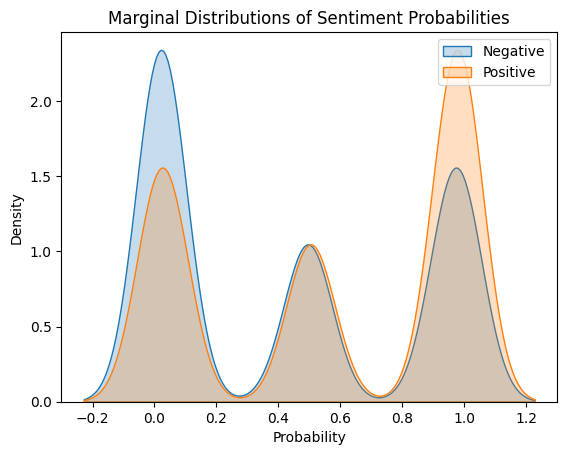

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_marginal_distributions(X_test):
    probs = classifier.predict_proba(X_test)
    fig, ax = plt.subplots()
    sns.kdeplot(probs[:, 0], ax=ax, shade=True, label='Negative')
    sns.kdeplot(probs[:, 1], ax=ax, shade=True, label='Positive')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Density')
    ax.set_title('Marginal Distributions of Sentiment Probabilities')
    ax.legend()
    plt.show()


plot_marginal_distributions(X_test_imdb_vec)

In [ ]:
def classify_text(text):
    processed_text = preprocess(text)
    text_vec = vectorizer.transform([processed_text])
    prediction = classifier.predict(text_vec)
    return prediction[0]

#__main__
#new_text = "I hated watching this movie. The acting was terrible and the story was boring."
#new_text = "The food at this restaurant was amazing. I highly recommend it."
#new_text = "I love my new phone. The camera is fantastic."
#new_text = "This phone is terrible. It keeps freezing and the battery life is awful."
#new_text = "The movie was great! I laughed so hard."
#new_text = "I thought the movie was boring and predictable."
#new_text = "I had a wonderful experience at this hotel. The staff was so friendly and helpful."
#new_text = "This hotel was a nightmare. The room was dirty and the staff was rude."

print(new_text)
print("Predicted sentiment:", classify_text(new_text))

I had a wonderful experience at this hotel. The staff was so friendly and helpful.
Predicted sentiment: pos


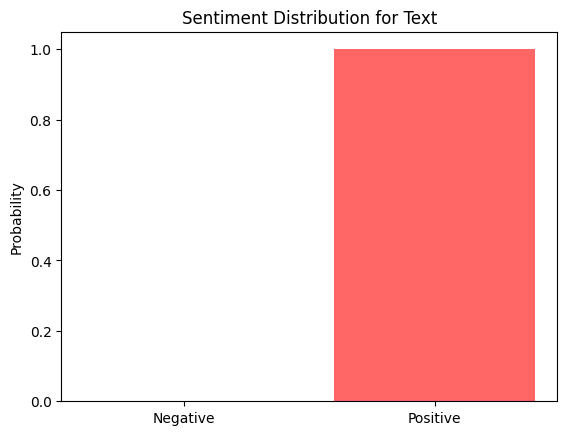

In [ ]:
import matplotlib.pyplot as plt

def plot_distributions(text):
    processed_text = preprocess(text)
    text_vec = vectorizer.transform([processed_text])
    probs = classifier.predict_proba(text_vec)[0]
    fig, ax = plt.subplots()
    x = range(len(probs))
    ax.bar(x, probs, color=['b', 'r'], alpha=0.6)

    ax.set_ylabel('Probability')
    ax.set_title('Sentiment Distribution for Text')
    ax.set_xticks(x)
    ax.set_xticklabels(['Negative', 'Positive'])

    plt.show()


#__main__
plot_distributions(new_text)
